In [1]:
from typing import Dict, Tuple
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML


## Utils

In [2]:
def unorm(x):
  return (x - x.min()) / (x.max() - x.min())

In [3]:
def plot_sample(samples, n_sample, nrows):
    ncols = n_sample//nrows
    samples = unorm(samples.cpu())
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Loop through each image and plot it
    for i in range(n_sample):
        # Select image
        image = samples[i]  # Shape [3, 16, 16]

        # Transpose to [16, 16, 3] for plotting
        image = image.permute(1, 2, 0)


        # Plot the image in the appropriate subplot
        axes[i].imshow(image)
        axes[i].axis('off')  # Hide axis
        axes[i].set_title(f'Image {i + 1}')  # Set title

    # Hide any unused subplots
    for j in range(n_sample, nrows * ncols):
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

## hyperparameters


In [4]:
# diffusion hyperparameters
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = '/content/'

# training hyperparameters
batch_size = 128
n_epoch = 40
lrate=1e-3

## Sprites Dataset

In [5]:
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy'
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprite_labels_nc_1788_16x16.npy'

--2024-12-27 17:28:35--  https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy
Resolving huggingface.co (huggingface.co)... 99.84.66.72, 99.84.66.112, 99.84.66.70, ...
Connecting to huggingface.co (huggingface.co)|99.84.66.72|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/df/b9/dfb98dd9f5f7c221e653770544f82ac8de0044d1f52ab71a1e42ed1a332ae365/61cf3b7e3184f57f2bc2bf5e75fbcf08ba379241f58966c62a9716ef581b2916?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sprites_1788_16x16.npy%3B+filename%3D%22sprites_1788_16x16.npy%22%3B&Expires=1735579715&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNTU3OTcxNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2RmL2I5L2RmYjk4ZGQ5ZjVmN2MyMjFlNjUzNzcwNTQ0ZjgyYWM4ZGUwMDQ0ZDFmNTJhYjcxYTFlNDJlZDFhMzMyYWUzNjUvNjFjZjNiN2UzMTg0ZjU3ZjJiYzJiZjVlN

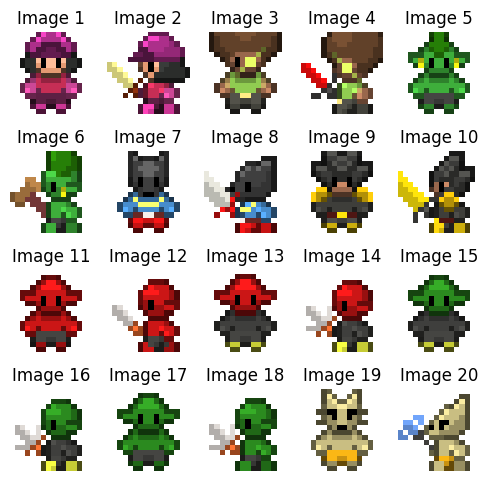

In [6]:
sprites_samples = np.load("/content/sprites_1788_16x16.npy")[:20]
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
axes = axes.flatten()

# Loop through each image and plot it
for i in range(20):
    image = sprites_samples[i]

    # Plot the image in the appropriate subplot
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis
    axes[i].set_title(f'Image {i + 1}')  # Set title

# Hide any unused subplots
for j in range(20, num_rows * num_cols):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [7]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, _sprites, _slabels, transform, null_context=False):
        self.transform = transform
        self.null_context = null_context
        self.sprites = _sprites
        self.slabels = _slabels
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]
])

In [8]:
sprites = np.load("/content/sprites_1788_16x16.npy")
slabels = np.load("/content/sprite_labels_nc_1788_16x16.npy")

print(f"sprite shape: {sprites.shape}")
print(f"labels shape: {slabels.shape}")


train_sprites = sprites[:60000]
train_slabels = slabels[:60000]
val_sprites = sprites[60000:]
val_slabels = slabels[60000:]


sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [9]:
# load dataset
trian_dataset = CustomDataset(train_sprites, train_slabels, transform, null_context=False)
train_dataloader = DataLoader(trian_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# load dataset
val_dataset = CustomDataset(val_sprites, val_slabels, transform, null_context=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## UNet

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

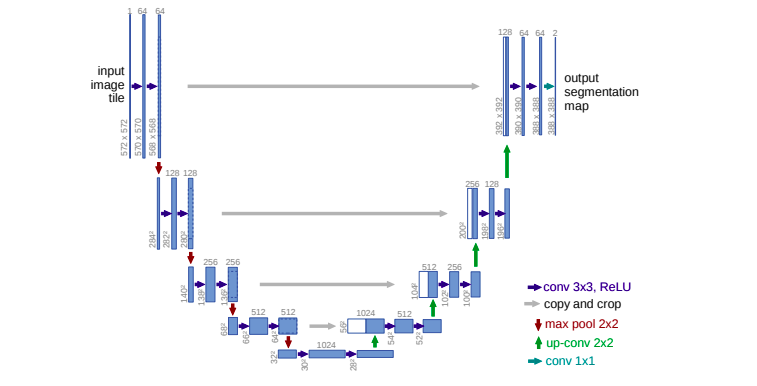

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks. Colorization , segmentation and so on. These days, typical unet models incorporate ideas such as attention and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks.

The implementation below is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [10]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

In [11]:
class Unet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(Unet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

## Training

In [12]:
# device = 'cuda'

# construct model
nn_model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [13]:
#construct optimizer
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

We want to set up a "**variance schedule**" β, where $\beta_t$ specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. \\
At each time step t, the variance of the noise added to the previous step is predetermined by the variance schedule, and it's marked as $\beta_t$, where 0 < $\beta_1$ < $\beta_t$ < $\beta_2$ < 1.

In [14]:
# TODO: complete the code here
# Create Linear Scheduler - beta1 and beta2 are given in the hyperparameters block

T = 1000  # Total timesteps
beta_1 = 1e-4  # Starting value of beta
beta_T = 0.02  # Ending value of beta

# Linear noise schedule
b_t = torch.linspace(beta_1, beta_T, T+1)  # Linearly spaced values of beta
alpha_t = 1.0 - b_t  # Define alpha_t
alpha_bar_t = torch.cumprod(alpha_t, dim=0)  # Cumulative product of alpha_t
alpha_bar_t = alpha_bar_t.to(device)


### Forward

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample.

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$.

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$


In [15]:
# helper function: perturbs an image to a specified noise level

# TODO: complete the code here
def perturb_input(x0, t, noise):
    """
    Perturb input image x0 at timestep t with Gaussian noise.

    Args:
        x0: Input image tensor [batch_size, channels, height, width].
        t: Timestep tensor [batch_size] (int values).

    Returns:
        Perturbed image xt.
    """
    alpha_bar = alpha_bar_t[t].view(-1, 1, 1, 1)
    xt = torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * noise
    return xt


### Train Diffsion

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

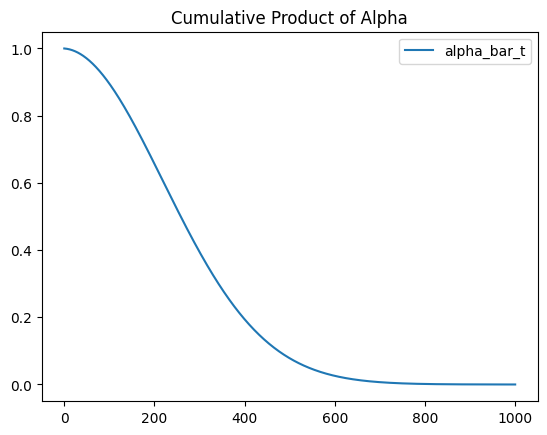

In [16]:
plt.plot(alpha_bar_t.cpu().numpy(), label='alpha_bar_t')
plt.title("Cumulative Product of Alpha")
plt.legend()
plt.show()


In [17]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample):
    nn_model.eval()
    samples = torch.randn(n_sample, 3, height, height).to(device)

    for t in reversed(range(0, T)):
        t_tensor = torch.tensor([t/T], device=device, dtype=torch.float32).repeat(n_sample)

        z = torch.randn_like(samples) if t > 1 else 0
        alpha = alpha_t[t]
        alpha_bar = alpha_bar_t[t]

        epsilon_theta = nn_model(samples, t_tensor)
        samples = (1 / torch.sqrt(alpha)) * (samples - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * epsilon_theta) + torch.sqrt(b_t[t]) * z

    return samples


Epoch 1


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.1409839242696762


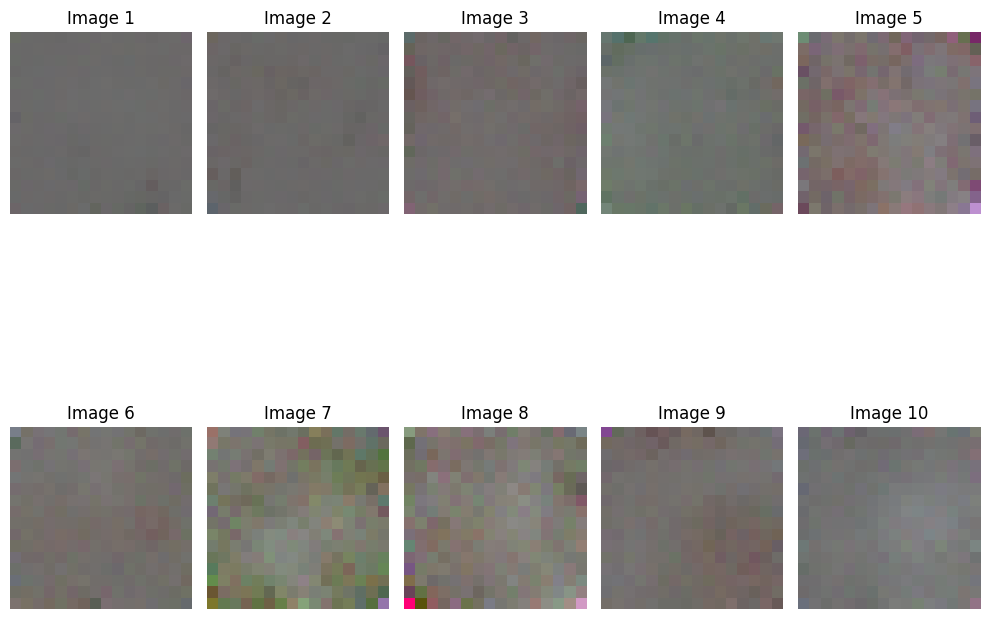

Epoch 2


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.11616742610931396


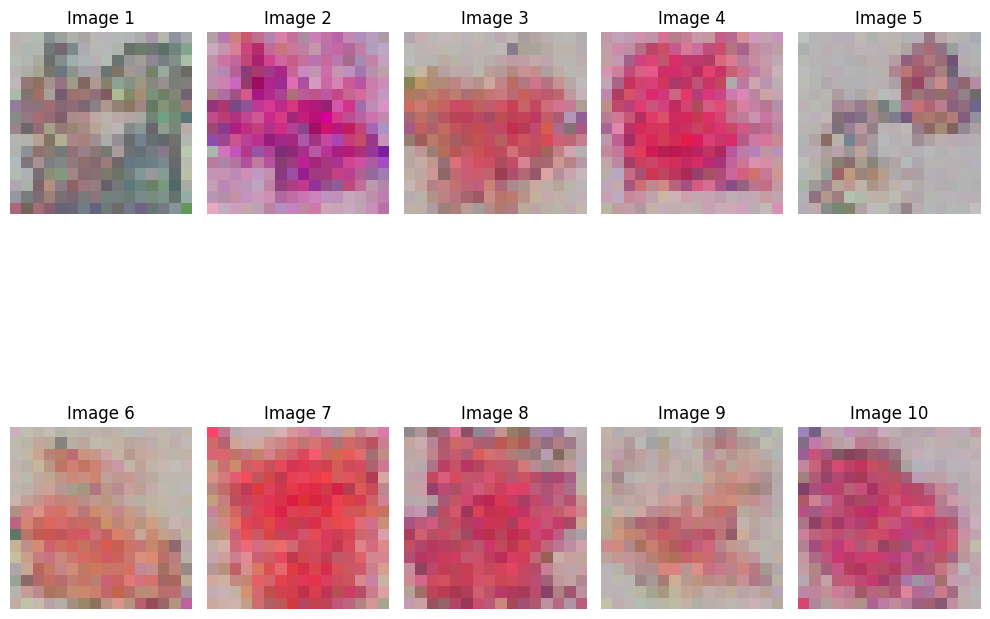

Epoch 3


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.1070019081234932


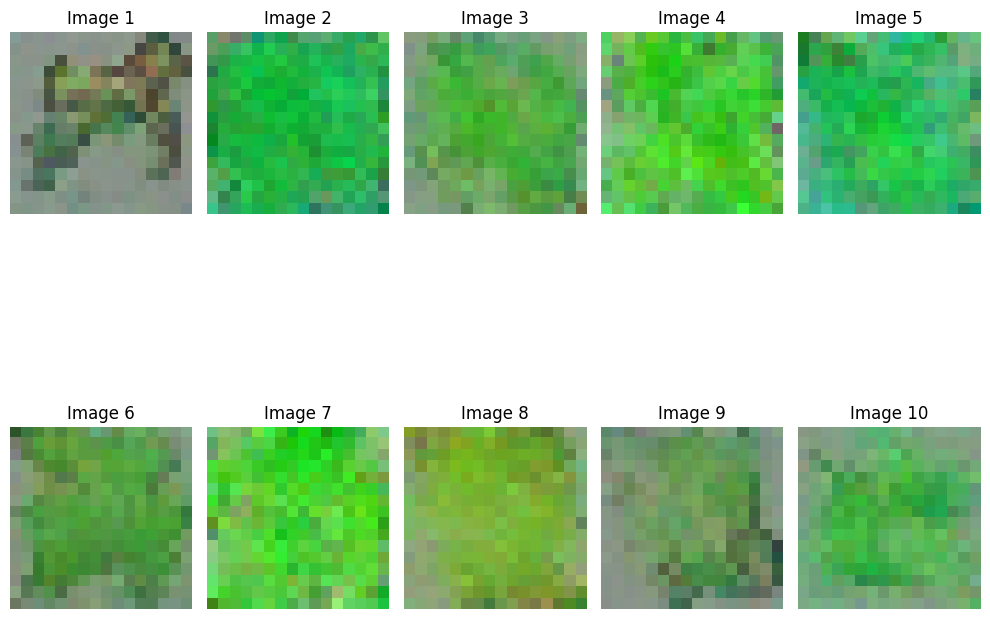

Epoch 4


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.09474599361419678


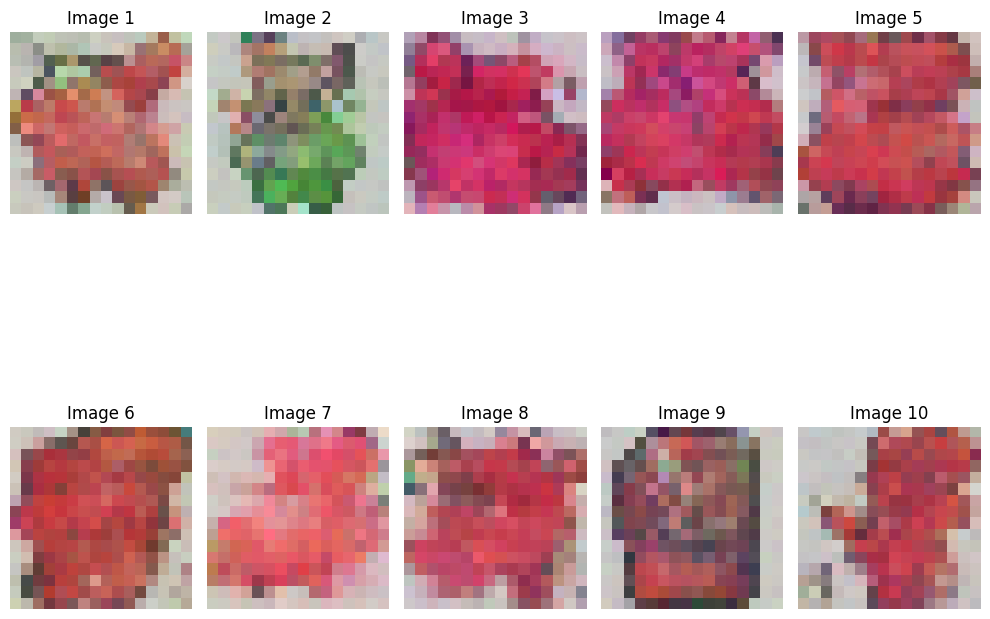

Epoch 5


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.09548341482877731


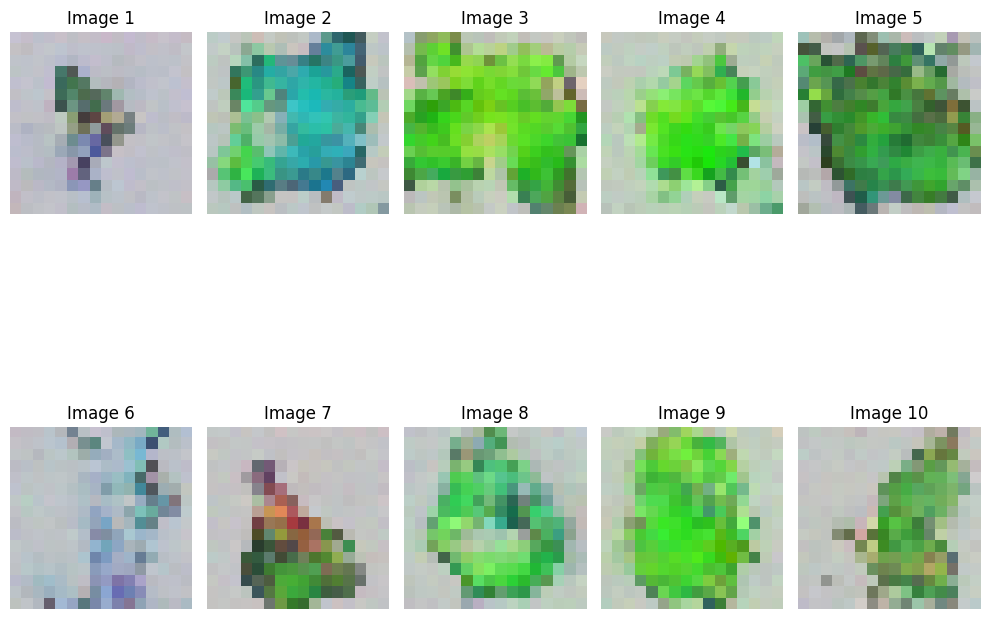

Epoch 6


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.06562206894159317


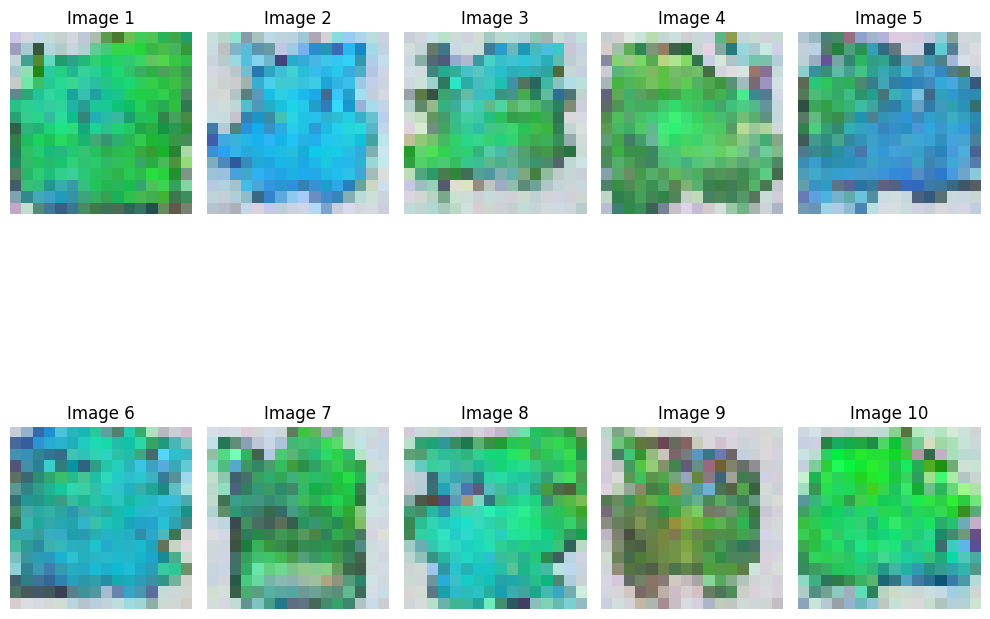

Epoch 7


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.08218567818403244


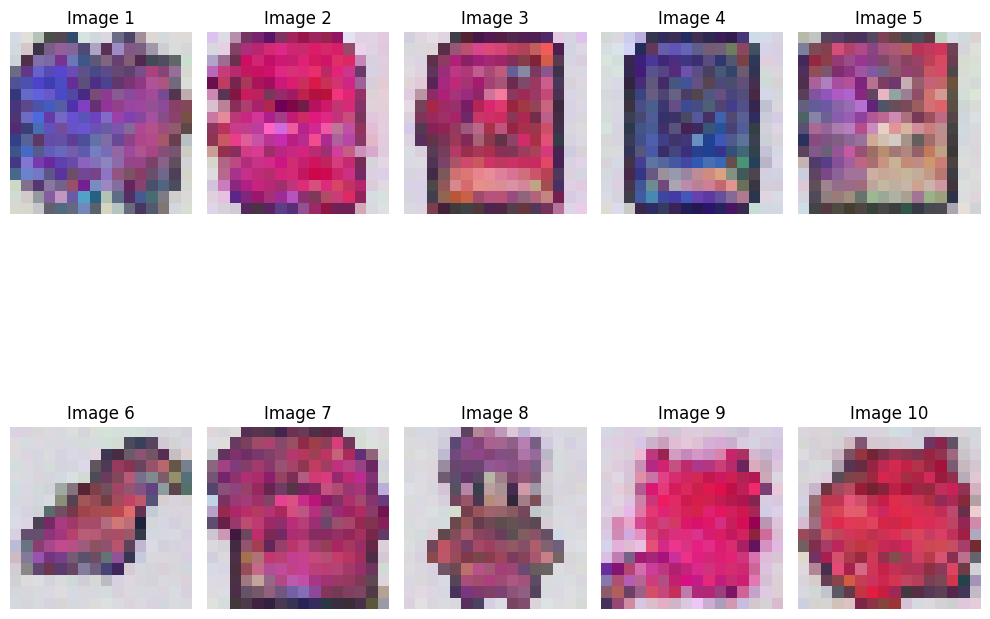

Epoch 8


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.09577644616365433


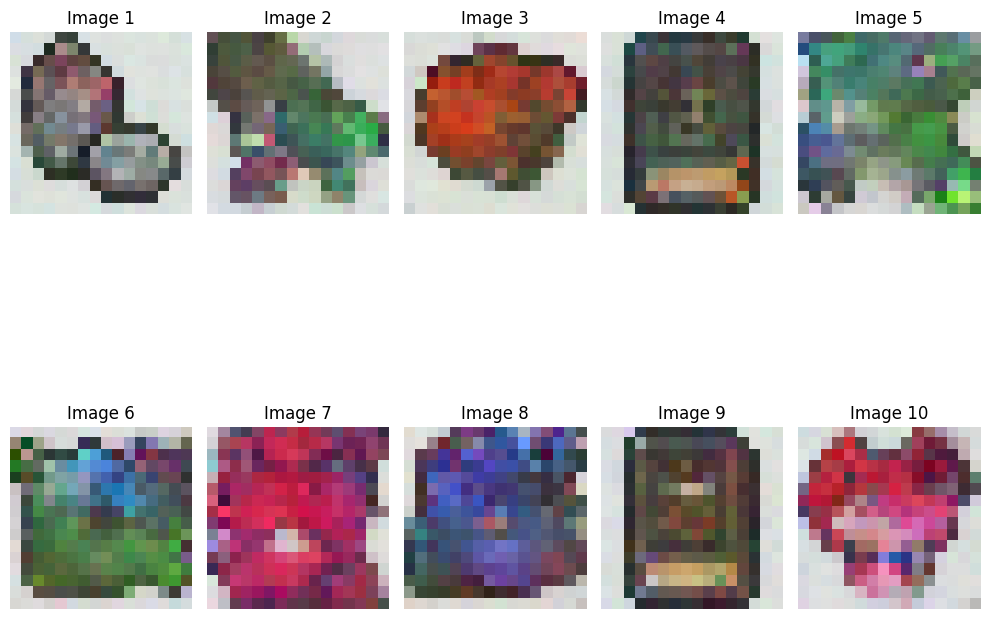

Epoch 9


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.05115029588341713


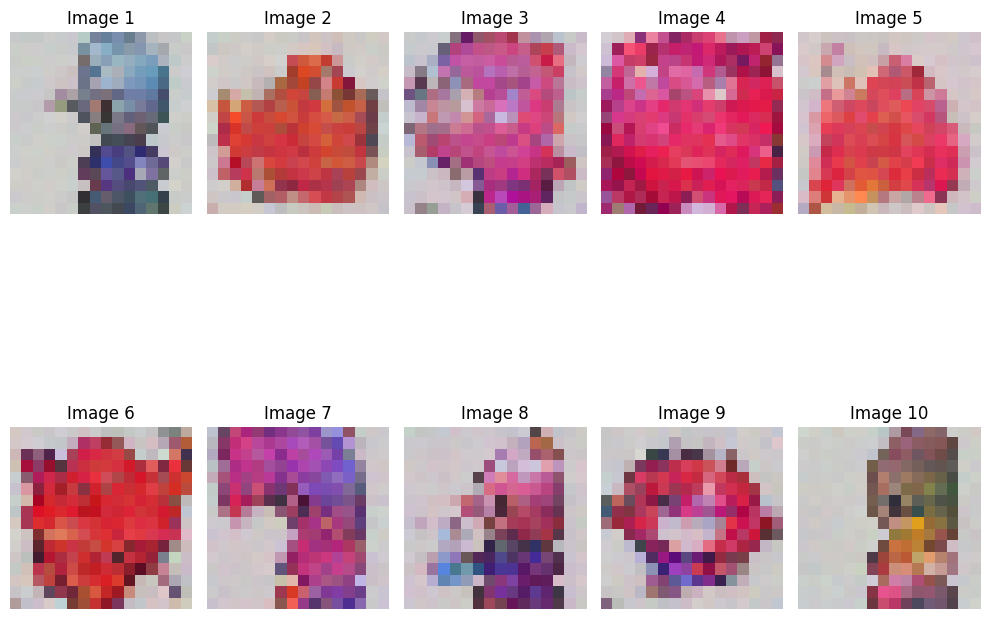

Epoch 10


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.06404126435518265


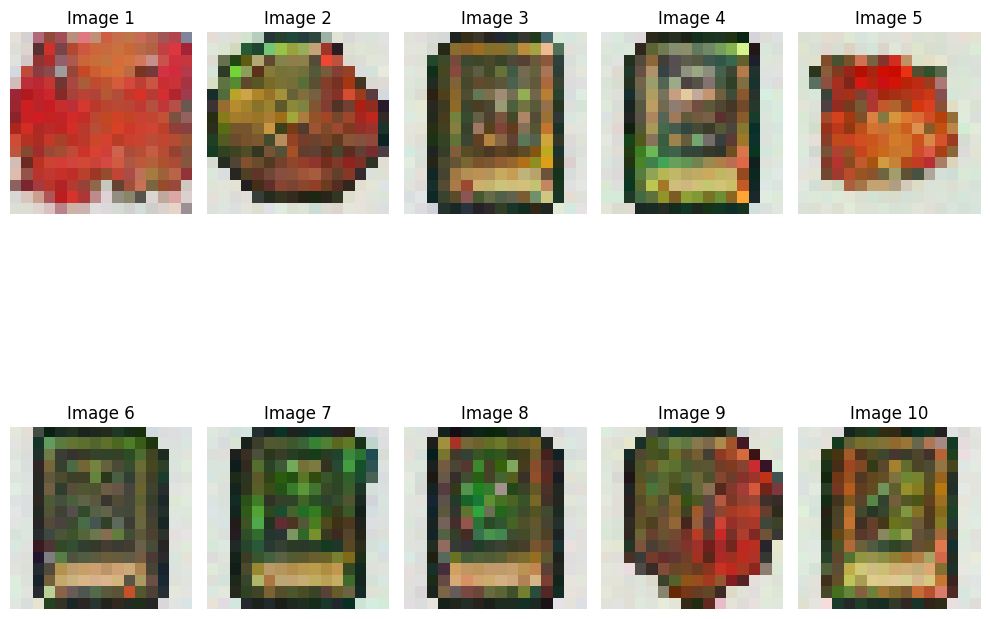

Epoch 11


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.08312661945819855


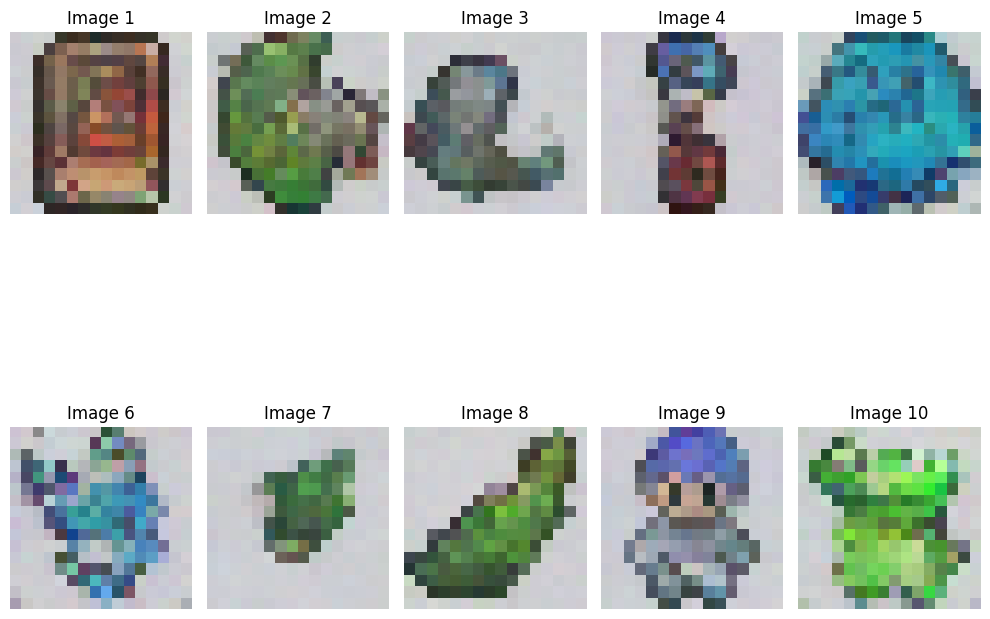

Epoch 12


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.06739717721939087


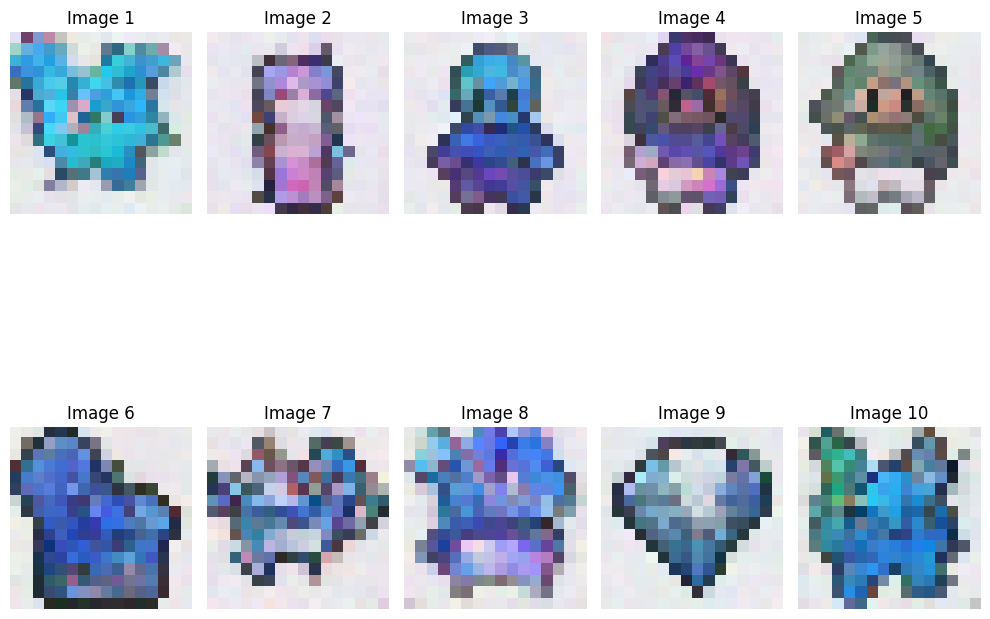

Epoch 13


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.05646128207445145


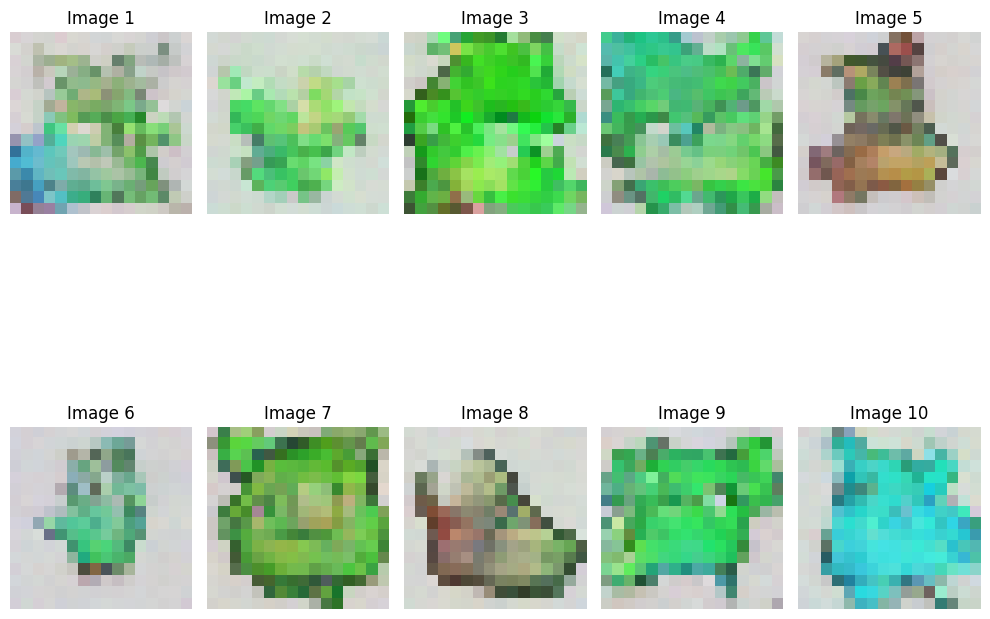

Epoch 14


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.05888160690665245


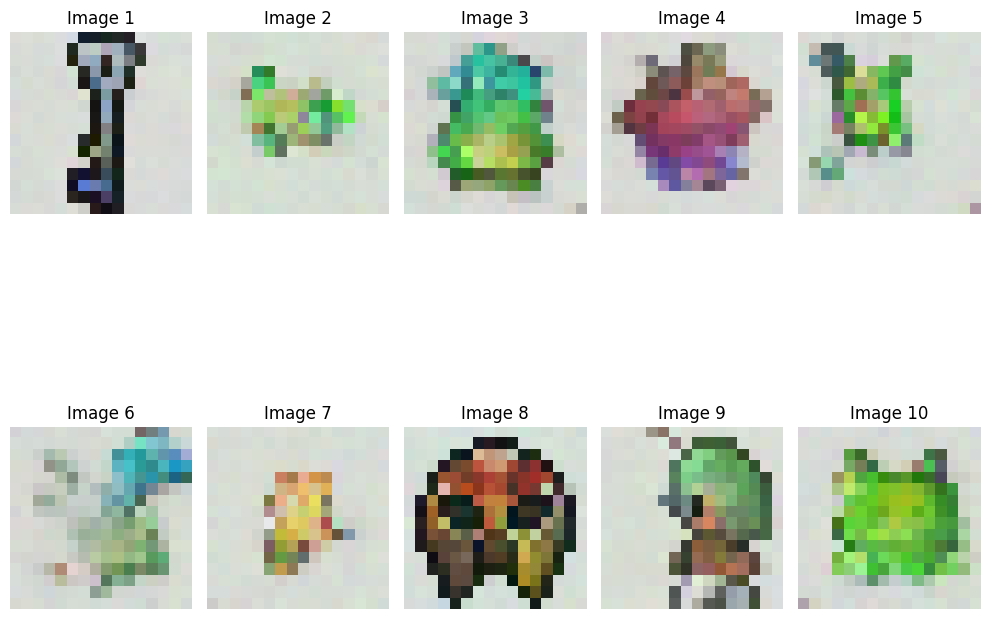

Epoch 15


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.08533260226249695


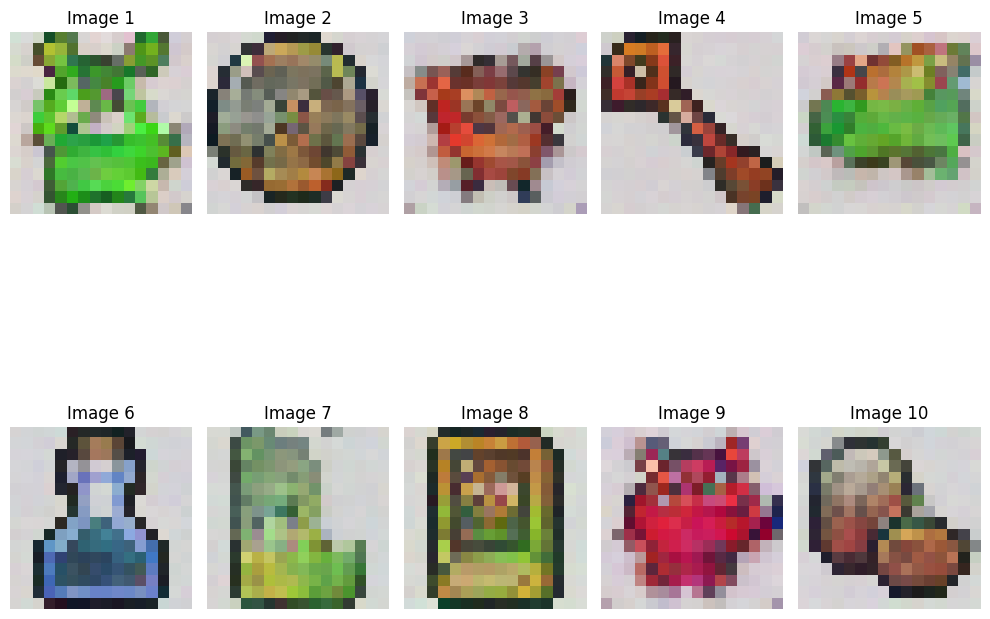

Epoch 16


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.055532243102788925


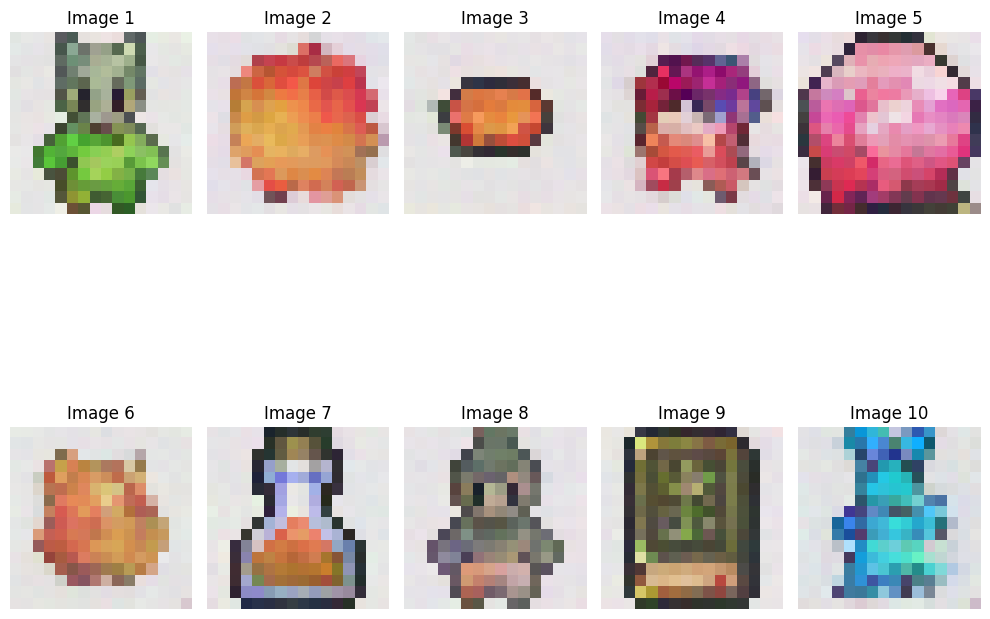

Epoch 17


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.09222208708524704


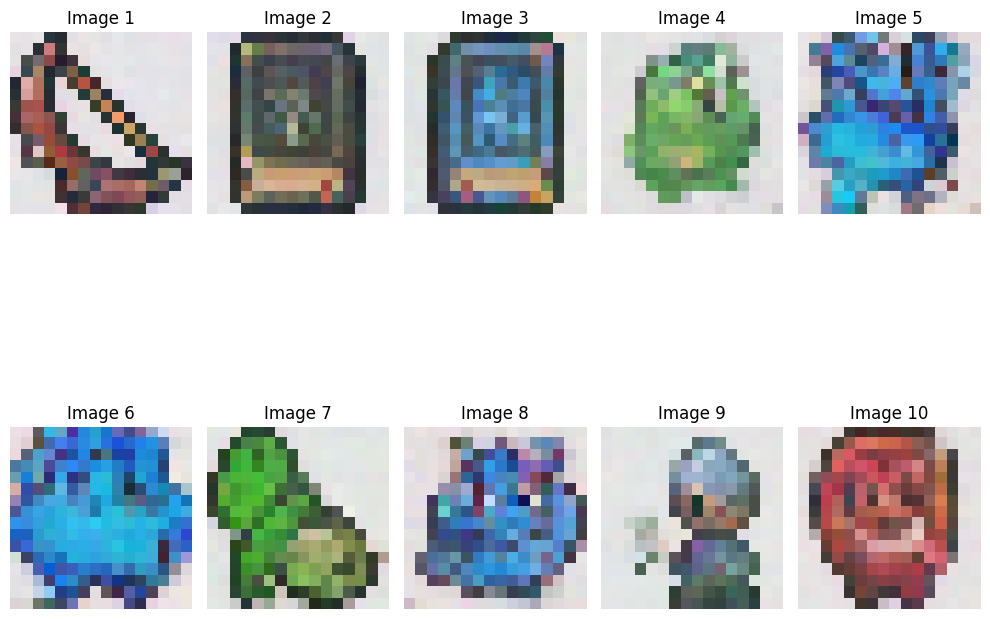

Epoch 18


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.05896729975938797


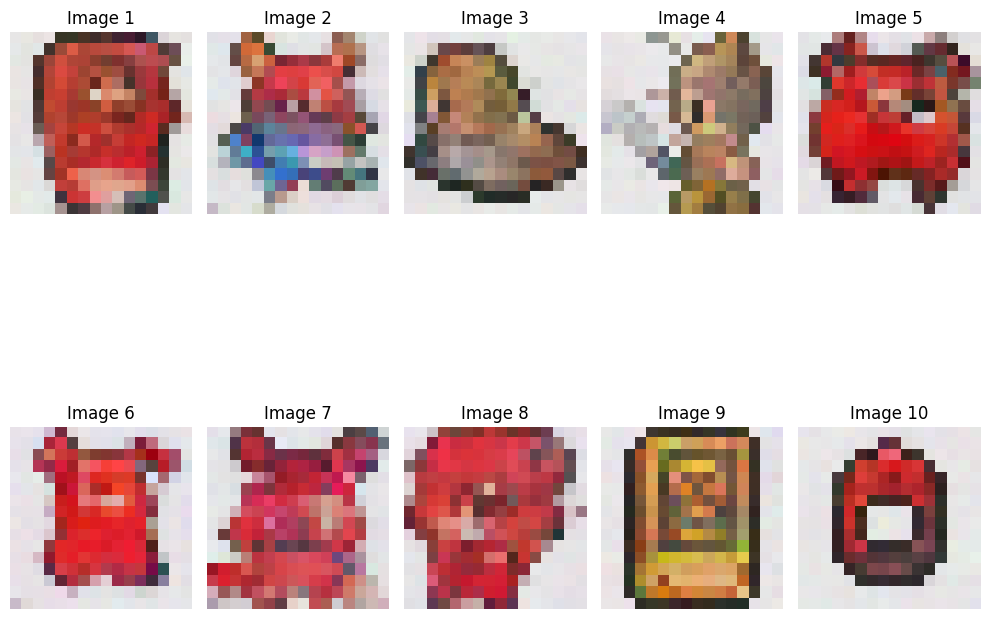

Epoch 19


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.0462772361934185


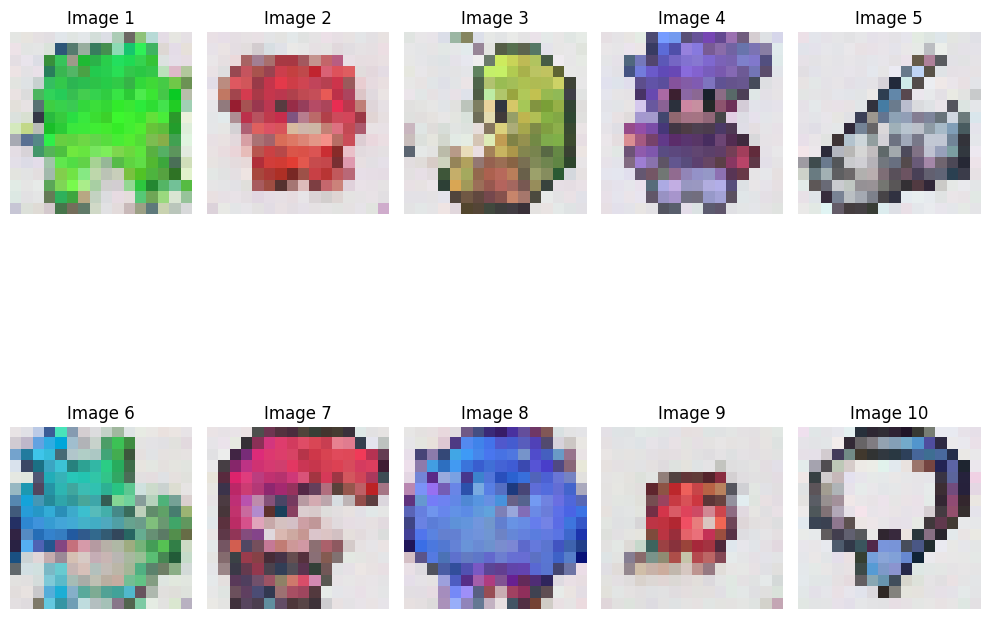

Epoch 20


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.08372868597507477


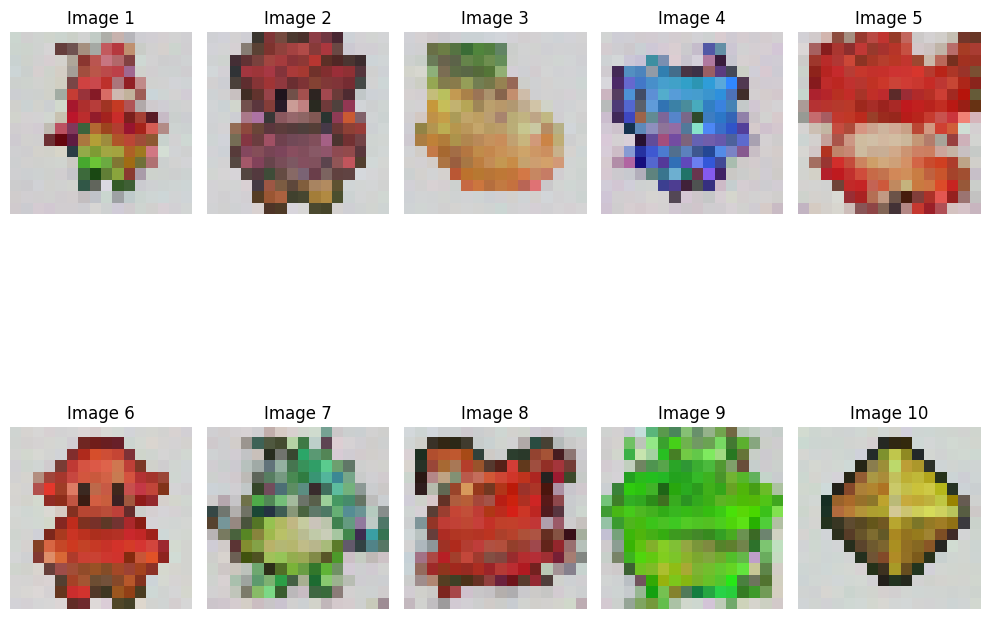

Epoch 21


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.04509652405977249


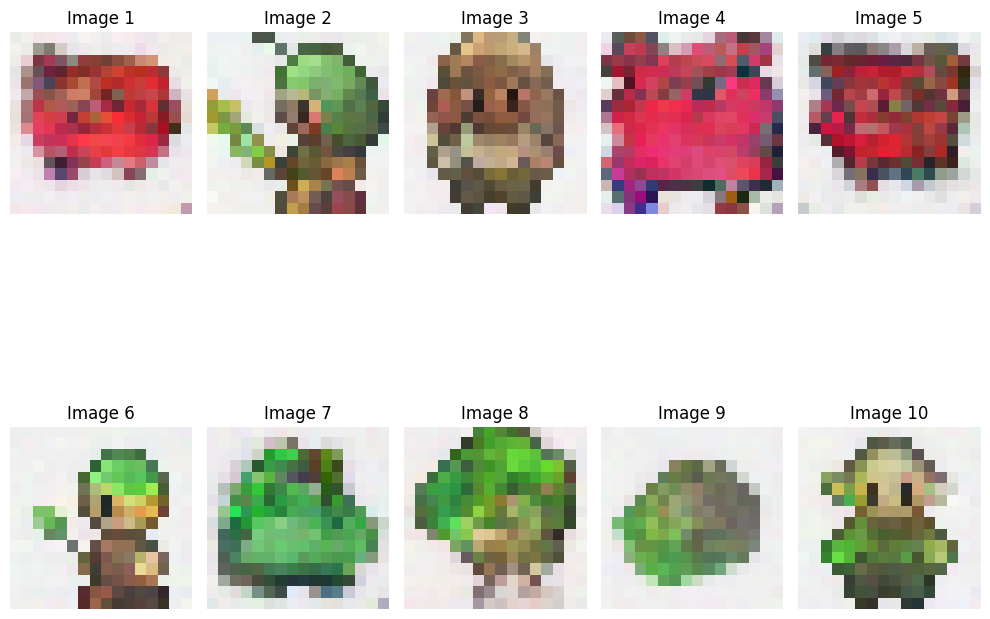

Epoch 22


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.04484091326594353


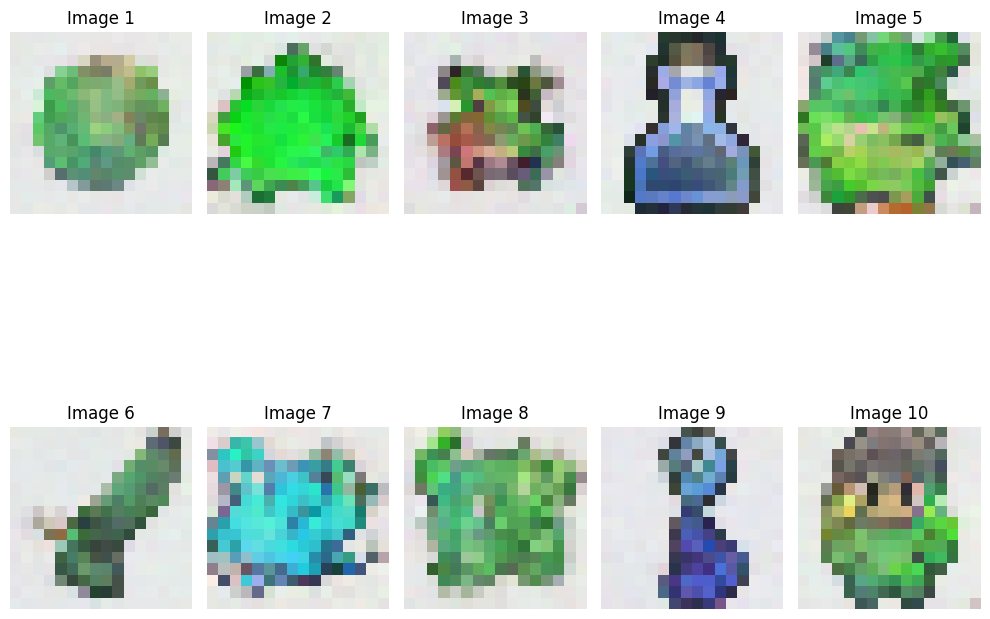

Epoch 23


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.06141064688563347


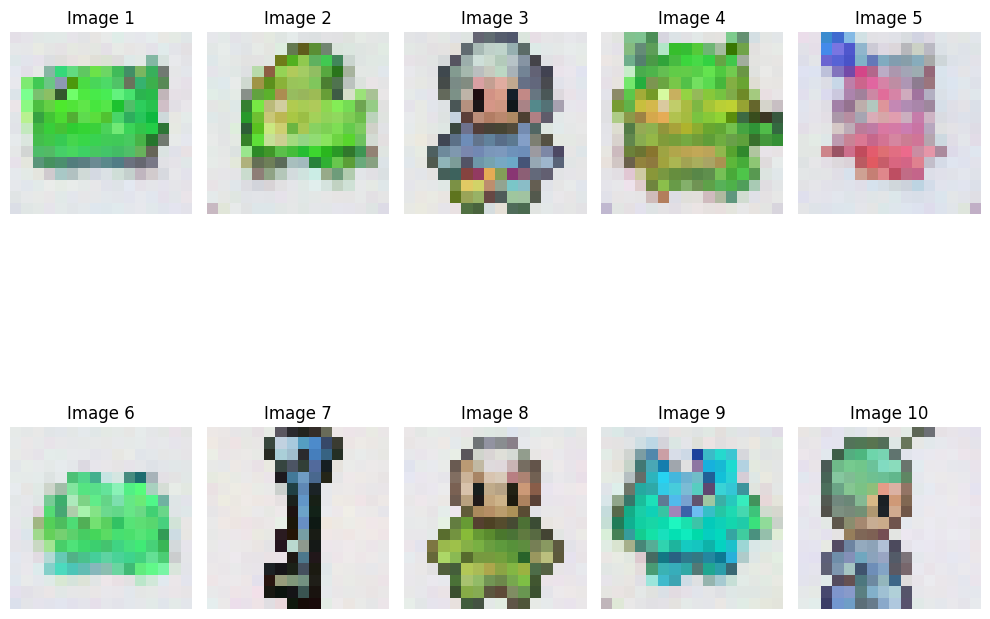

Epoch 24


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.06382054835557938


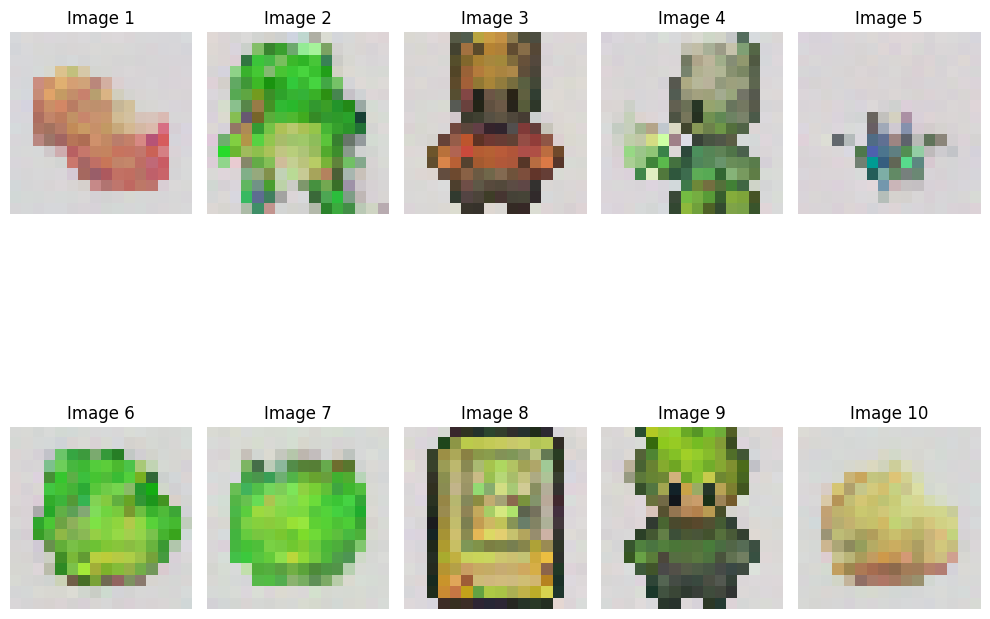

Epoch 25


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.03635062277317047


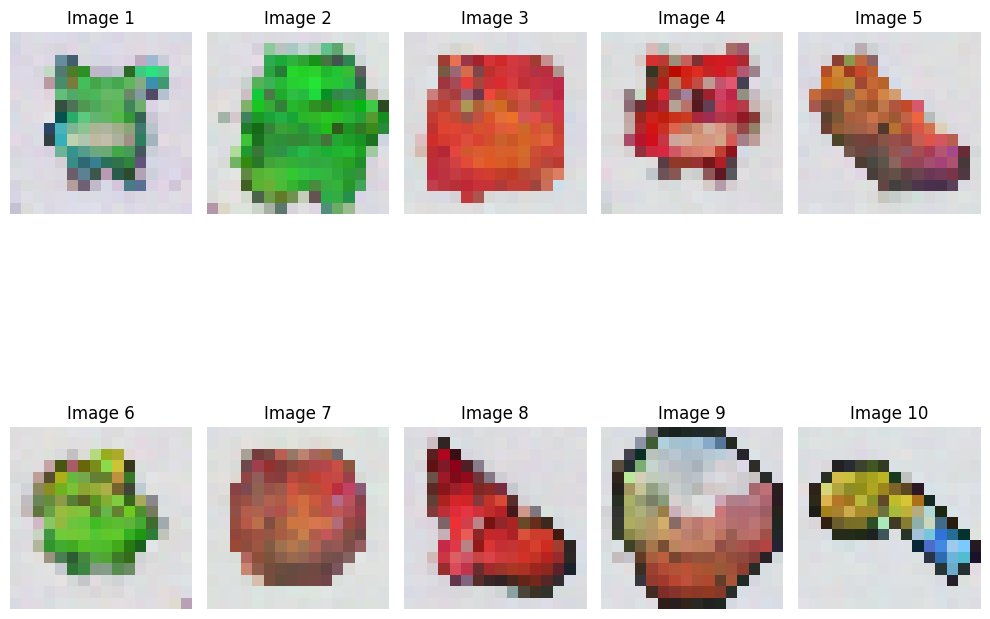

Epoch 26


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.0551125705242157


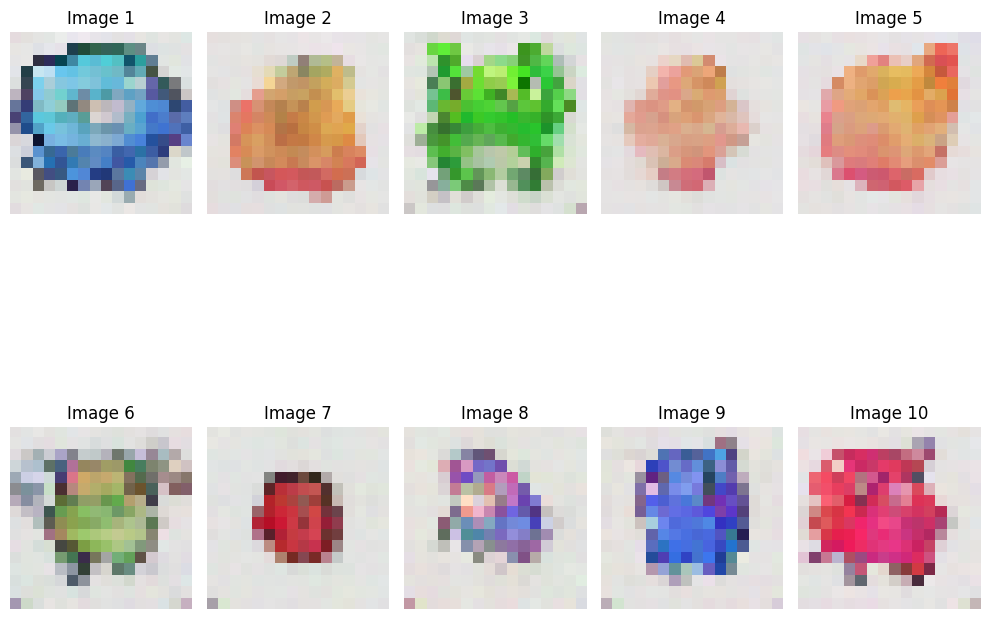

Epoch 27


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.05121474340558052


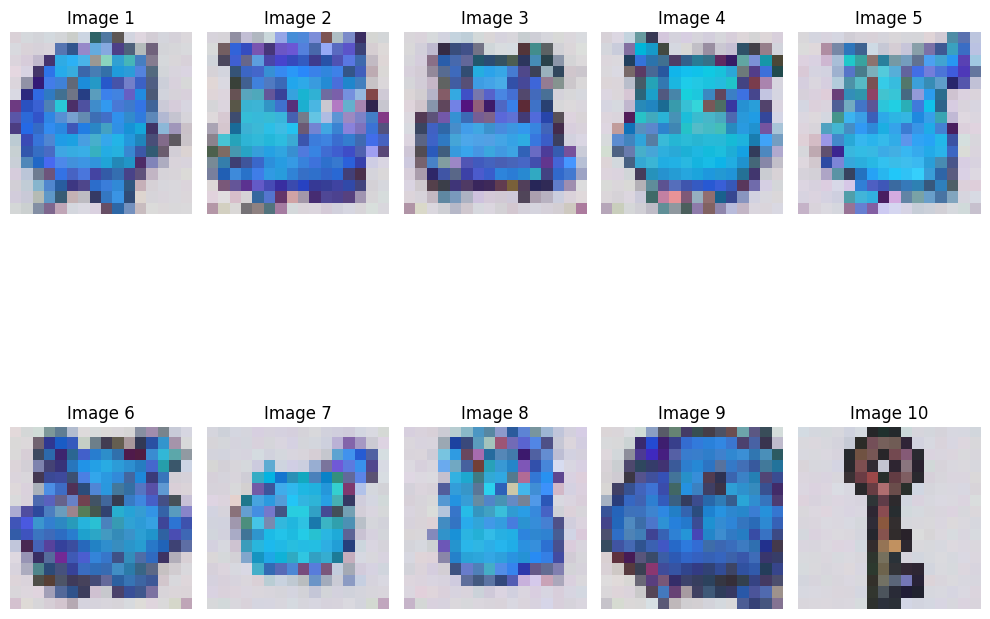

Epoch 28


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.046107079833745956


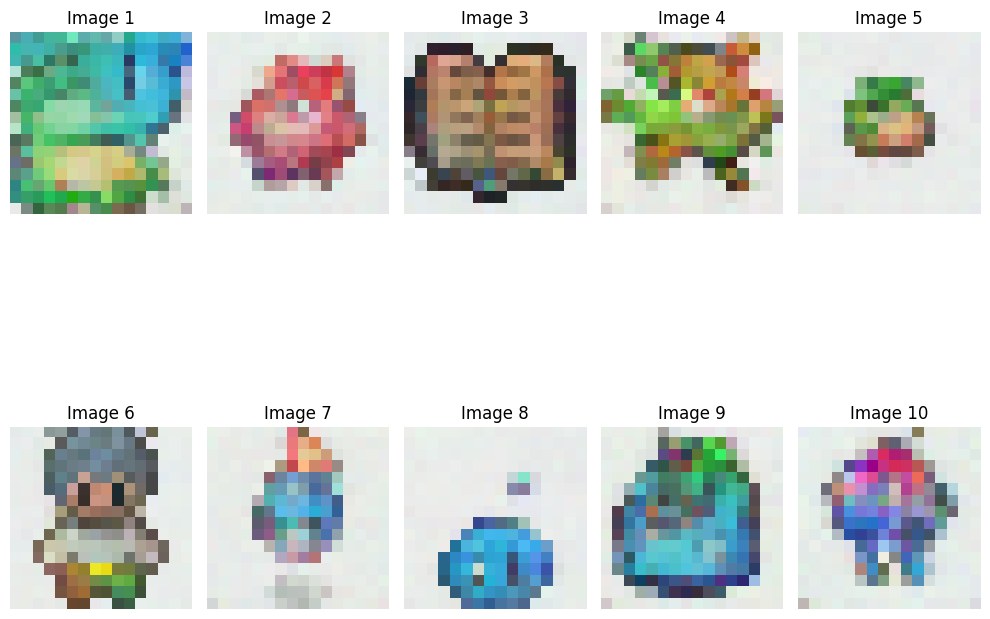

Epoch 29


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.0479758195579052


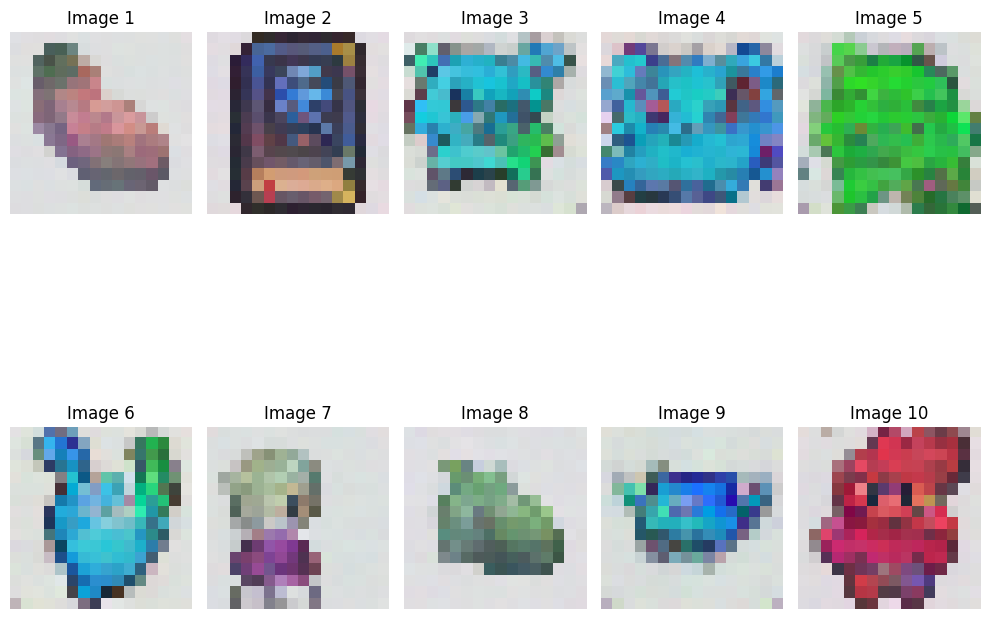

Epoch 30


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.05991065502166748


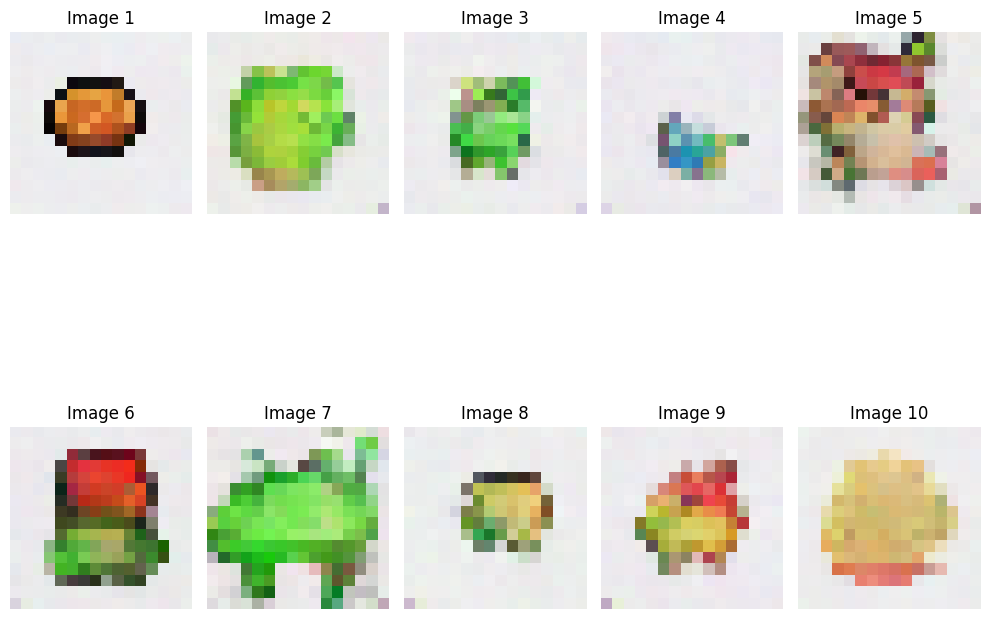

Epoch 31


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.041697025299072266


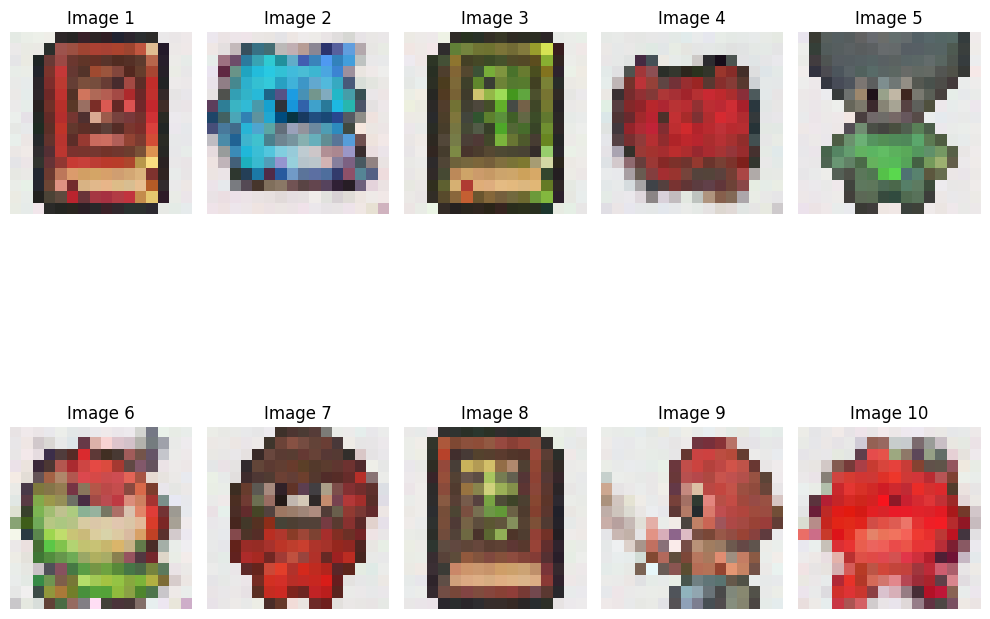

Epoch 32


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.03786918520927429


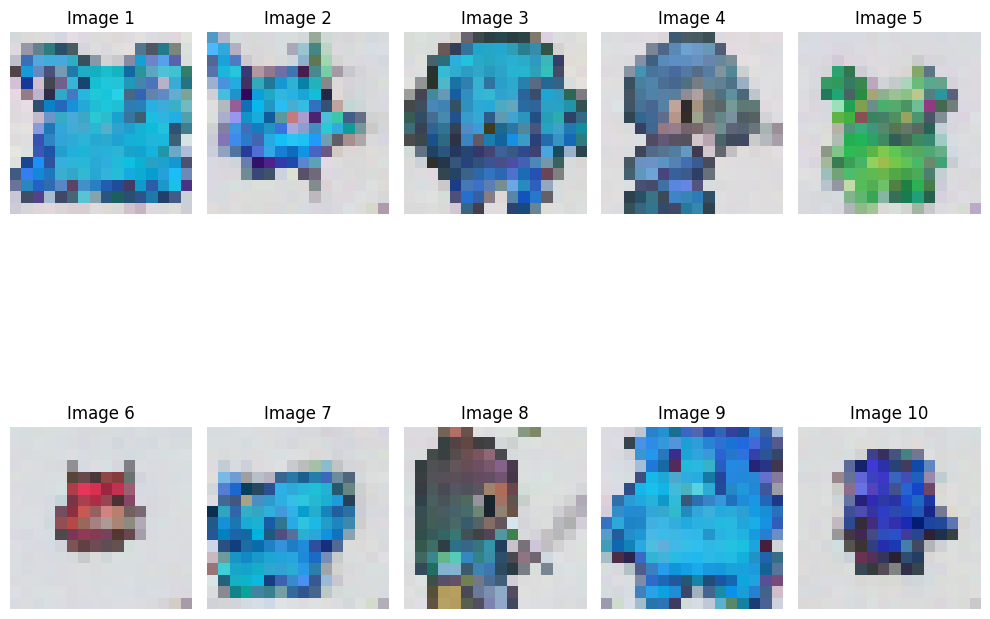

Epoch 33


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.043046802282333374


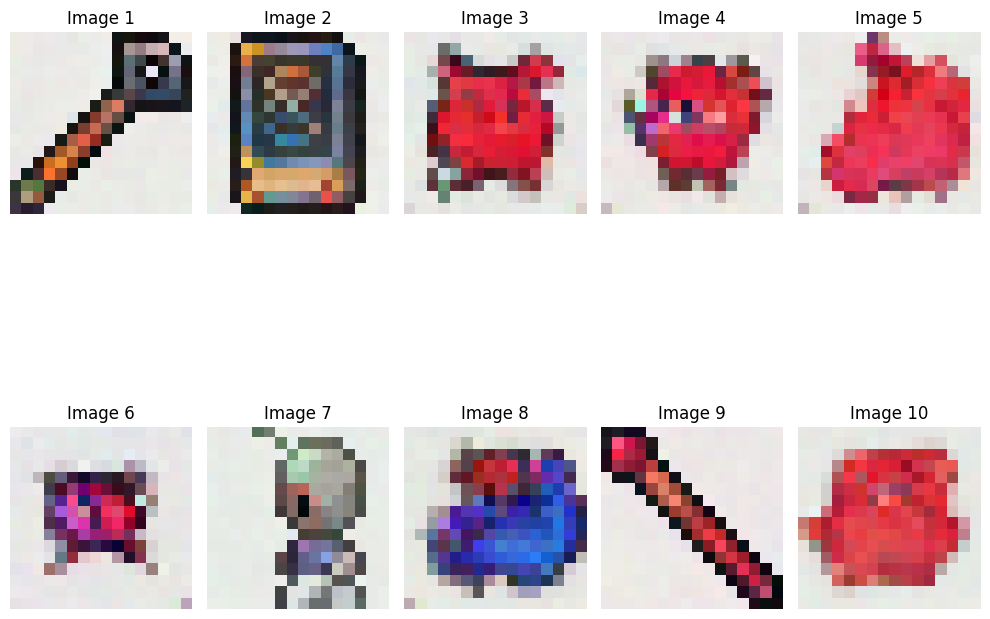

Epoch 34


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.031759459525346756


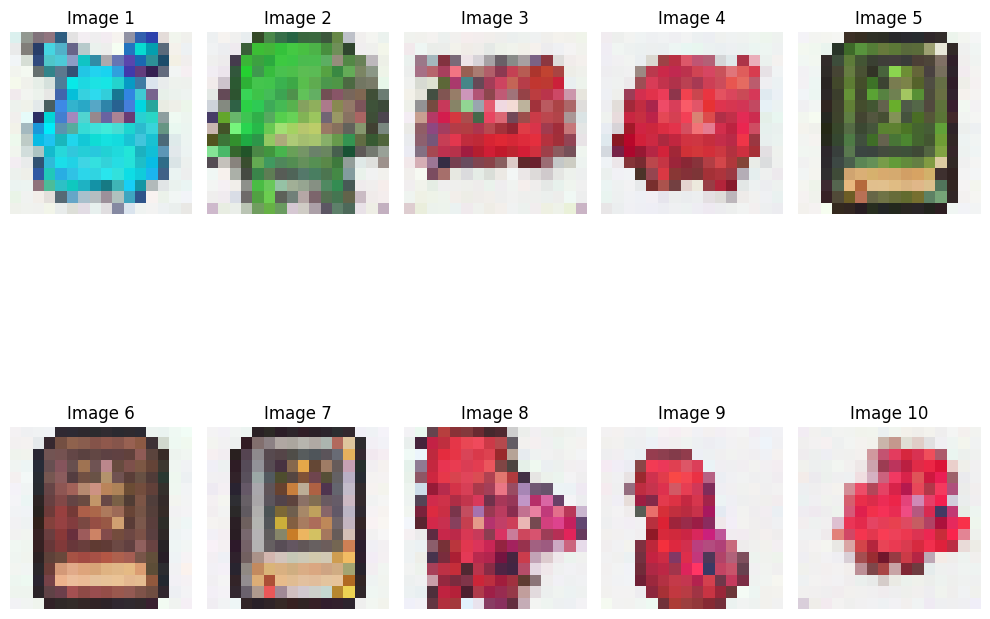

Epoch 35


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.042487312108278275


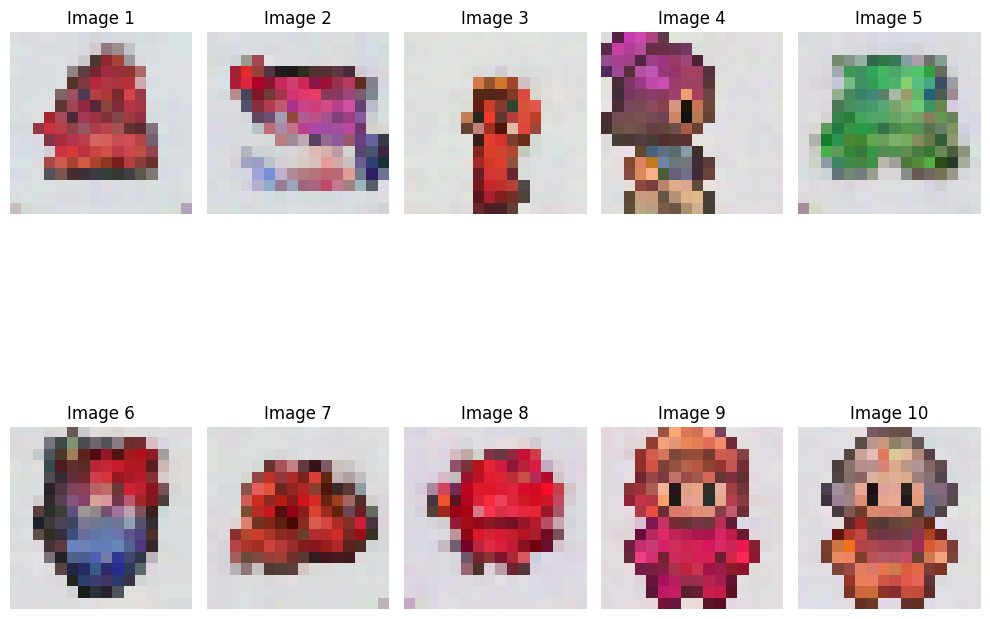

Epoch 36


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.030641794204711914


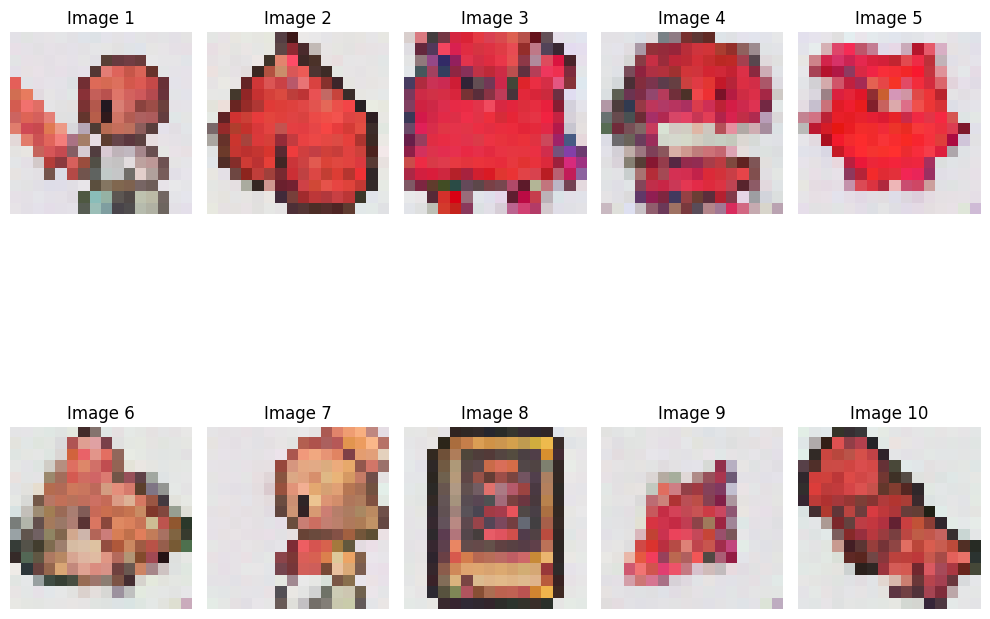

Epoch 37


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.027455542236566544


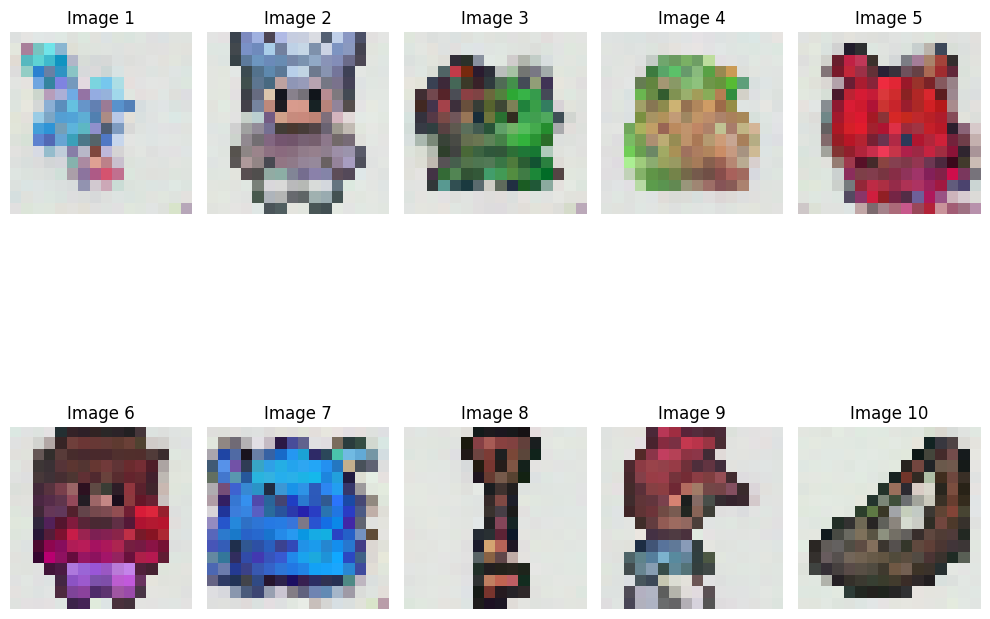

Epoch 38


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.0367082916200161


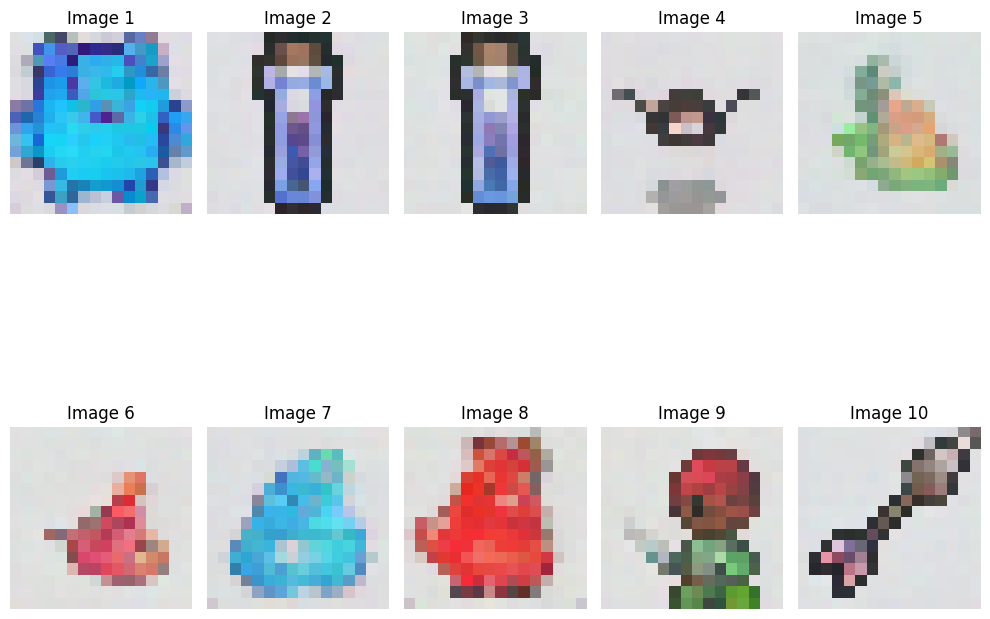

Epoch 39


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.0459546335041523


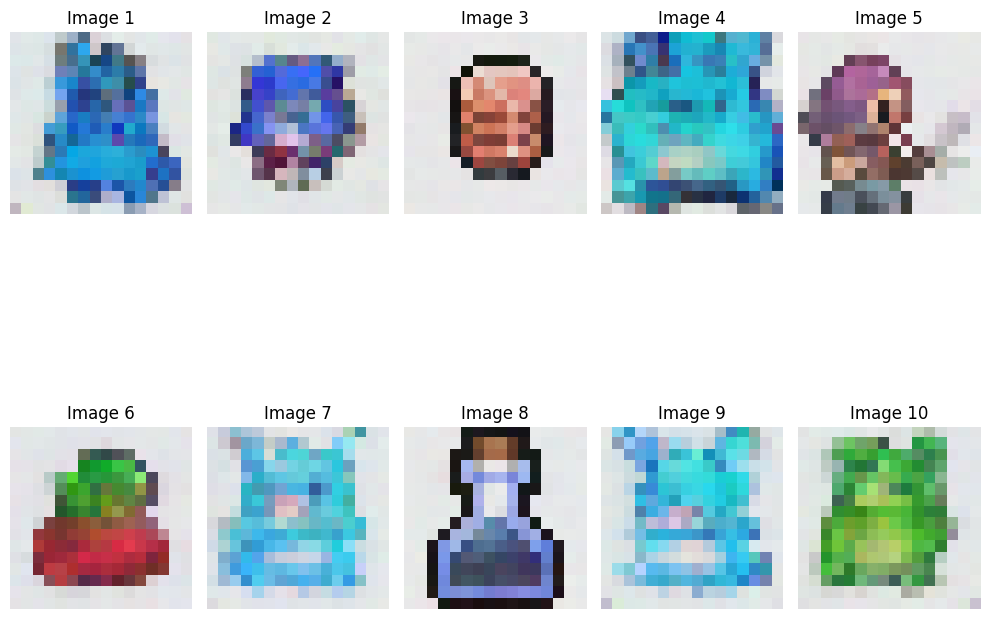

Epoch 40


  0%|          | 0/469 [00:00<?, ?it/s]

Loss: 0.03185747563838959


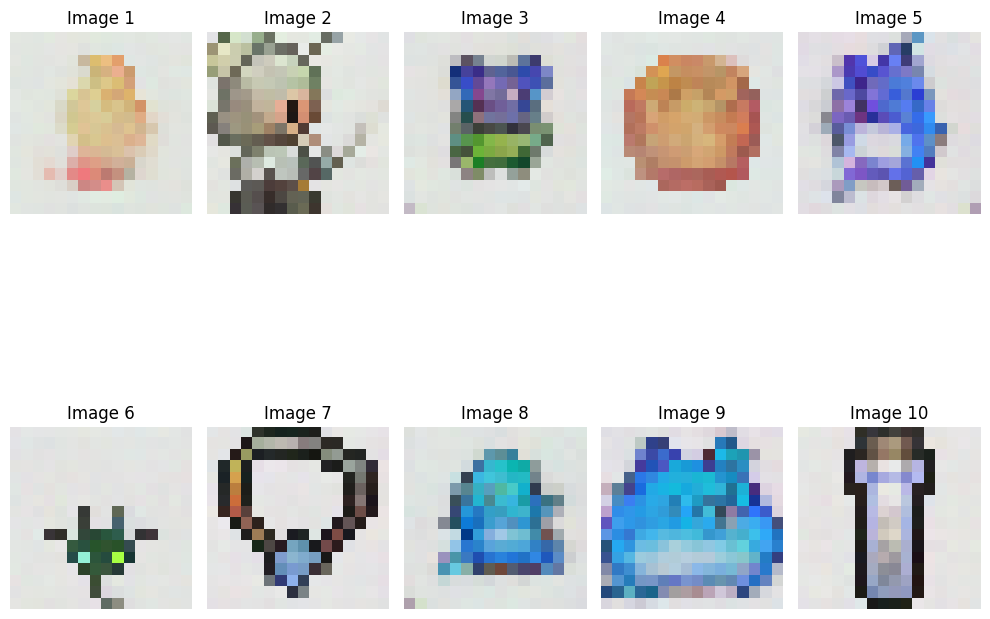

In [18]:
# Train Model

# TODO: complete the code here
nn_model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
nn_model.train()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=5e-4)
num_generated_samples = 10
loss_function = torch.nn.MSELoss()

def display_samples(samples, title="Generated Samples"):
    """
    Display a grid of generated images.

    Args:
        samples (torch.Tensor): Tensor containing generated images.
        title (str): Title of the plot.
    """
    # Normalize images to the [0, 1] range for visualization
    samples = (samples + 1) / 2
    grid = make_grid(samples, nrow=5)

    # Plot the images in a grid
    plt.figure(figsize=(10, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title(title)
    plt.show()

# Training loop
for epoch in range(n_epoch):
    print(f'Epoch {epoch + 1}')
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()  # Reset gradients before backpropagation

        # Retrieve the input batch and move it to the device
        input_images = batch[0].to(device)

        # Sample random timesteps for each image in the batch
        timesteps = torch.randint(0, T, (input_images.size(0),), device=device)

        # Perturb the input images using the forward process with added noise
        noise = torch.randn_like(input_images)  # Generate Gaussian noise
        perturbed_images = perturb_input(input_images, timesteps, noise)  # Perturbed input for the current timestep

        # Predict the added noise using the neural network
        timesteps = timesteps.float()  # Convert timesteps to float for model input
        predicted_noise = nn_model(perturbed_images, timesteps / T)  # Scale timesteps to [0, 1]

        # Compute the loss between predicted and actual noise
        loss = loss_function(predicted_noise, noise)

        # Perform backpropagation with gradient scaling
        loss.backward()
        optimizer.step()

    # Display the loss for the epoch
    print(f'Loss: {loss.item()}')

    # Generate and display samples after each epoch
    nn_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        generated_samples = sample_ddpm(num_generated_samples)  # Call the sampling function
        plot_sample(generated_samples, num_generated_samples, 2)  # Display the generated samples
    nn_model.train()  # Reset the model to training mode


## Save model and load it

In [19]:
model_path = "/content/nn_model.pth"

# Save the model's state dictionary
torch.save(nn_model.state_dict(), model_path)
print(f"Model parameters saved to {model_path}")

nn_model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
model_path = "/content/nn_model.pth"  # Path to the saved model

# Load the state dictionary into the model
nn_model.load_state_dict(torch.load(model_path))

nn_model.eval()


Model parameters saved to /content/nn_model.pth


<ipython-input-19-b21f58464256>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load(model_path))


Unet(
  (init_conv): ResidualConvBlock(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
  )
  (down1): UnetDown(
    (model): Sequential(
      (0): ResidualConvBlock(
        (conv1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')
        )
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, mome

## DDPM Sampling

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that looks like a real image. \\
Below image show the sampling algorithm

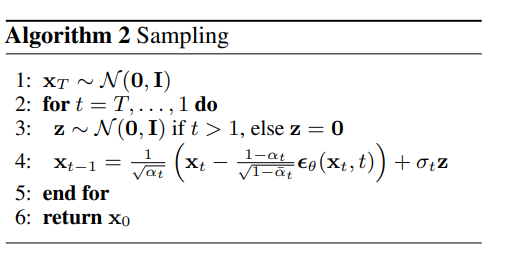

## DDIM Sampling

In [20]:
@torch.no_grad()
def sample_ddim(n_sample):
    nn_model.eval()
    samples = torch.randn(n_sample, 3, height, height).to(device)
    step_size = T // 20

    for t in range(T, 0, -step_size):
        t_tensor = torch.tensor([t/T], device=device, dtype=torch.float32).repeat(n_sample)

        z = torch.randn_like(samples) if t > 1 else 0
        alpha = alpha_bar_t[t]
        alpha_bar = alpha_bar_t[t-step_size]

        epsilon_theta = nn_model(samples, t_tensor)
        samples = (torch.sqrt(alpha_bar) / torch.sqrt(alpha)) * (samples - torch.sqrt(1 - alpha) * epsilon_theta) + torch.sqrt(1 - alpha_bar) * z


    return samples


## Results

In [21]:
samples = sample_ddpm(50)

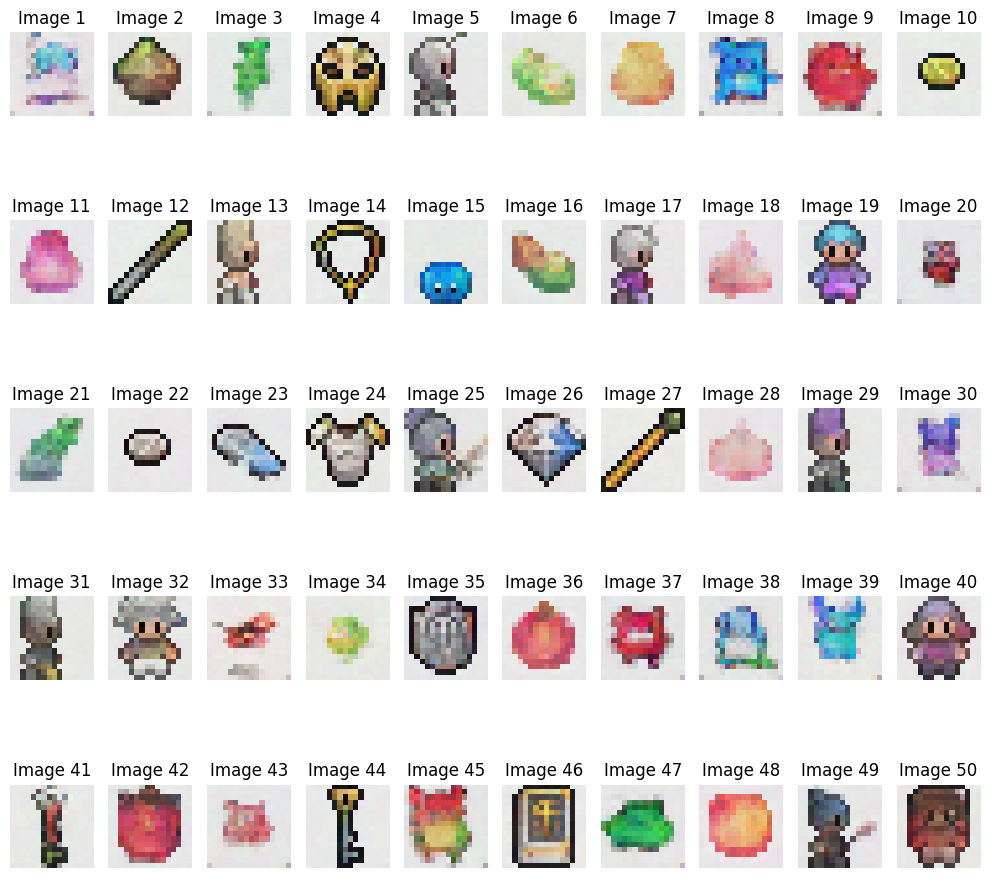

In [22]:
plot_sample(samples, 50, 5)

In [23]:
samples = sample_ddim(50)

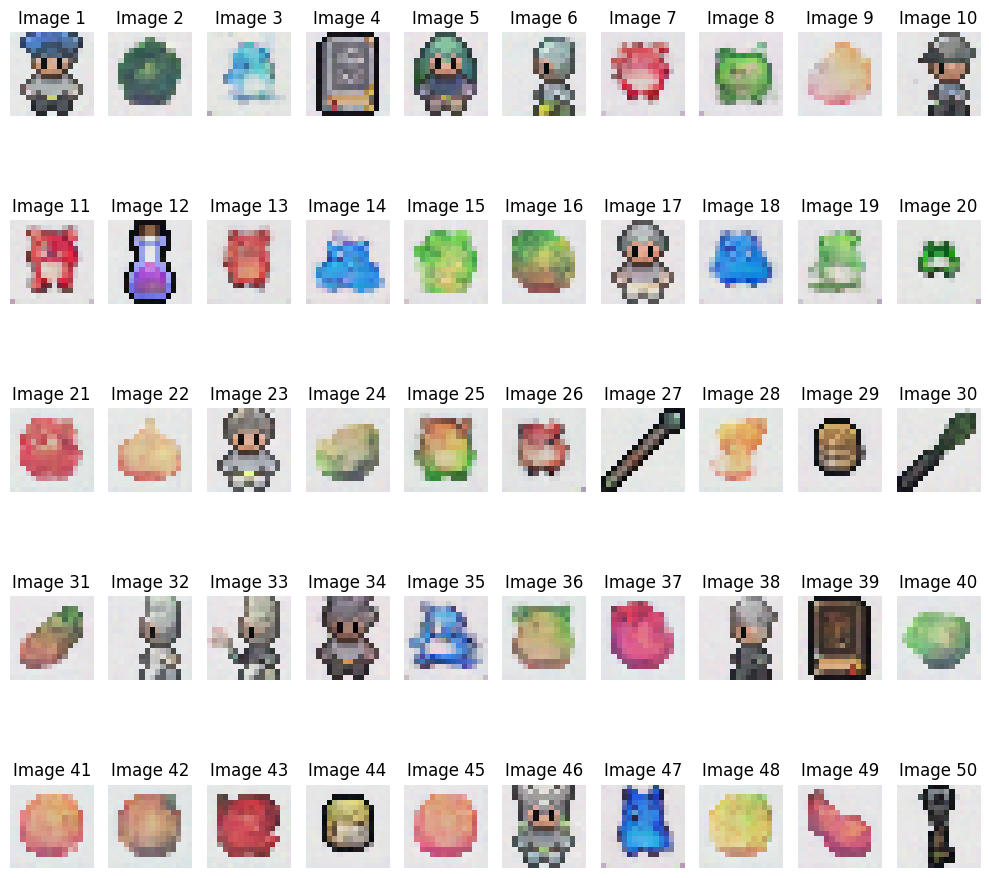

In [24]:
plot_sample(samples, 50, 5)

# Compare DDIM and DDPM Time

In [25]:
%timeit -r 1 sample_ddim(50)
%timeit -r 1 sample_ddpm(50)

123 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
6.24 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Evaluating the Generated Samples:

Now we want to evaluate our model. For this, we use the FID score.

First, read this link to become familiar with this metric and its usage in your code.

In [26]:
!pip install torch-fidelity


In [27]:
# TODO: complete the code here

import os
import tempfile
from PIL import Image
import torch
from torch_fidelity import calculate_metrics

def save_images_to_tempdir(images, temp_dir):
    """
    Save a batch of images to a temporary directory.
    :param images: Tensor or NumPy array of shape (N, H, W, C) or (N, H, W) for grayscale.
    :param temp_dir: Path to the directory where images will be saved.
    """
    for i, image in enumerate(images):
        # Check image shape and handle appropriately
        if image.ndim == 4:  # Shape: (1, 1, H, W) or similar
            image = image.squeeze()  # Remove unnecessary dimensions
        elif image.ndim == 3 and image.shape[-1] not in [1, 3]:  # Handle extra channels
            image = image[:, :, :3]  # Keep only the first 3 channels
        elif image.ndim == 2:  # Already grayscale
            # Convert grayscale to RGB
            image = np.stack([image] * 3, axis=-1)  # Grayscale to RGB
        elif image.ndim == 3 and image.shape[-1] in [1, 3]:  # Valid RGB/Grayscale
            pass  # Valid shape, do nothing
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")

        # Convert to uint8 if needed
        image = (image * 255).astype(np.uint8) if image.dtype != np.uint8 else image

        # Save the image as PNG
        img = Image.fromarray(image)
        img.save(os.path.join(temp_dir, f"{i}.png"))



def evaluate_fid(real_images, generated_images):
    """
    Calculate FID score between real and generated images.

    :param real_images: Numpy array or torch.Tensor of real images (N, H, W, C)
    :param generated_images: Numpy array or torch.Tensor of generated images (N, H, W, C)
    :return: FID score
    """
    # Create temporary directories for real and generated images
    with tempfile.TemporaryDirectory() as real_dir, tempfile.TemporaryDirectory() as gen_dir:
        save_images_to_tempdir(real_images, real_dir)
        save_images_to_tempdir(generated_images, gen_dir)

        # Compute metrics
        metrics = calculate_metrics(
            input1=real_dir,
            input2=gen_dir,
            fid=True,
            verbose=True
        )
    return metrics['frechet_inception_distance']


# Assuming val_sprites are real images and sample_ddpm generates samples
real_sprites = val_sprites[:10000]  # Use a subset for testing
ddpm_generated_samples = sample_ddpm(1000).cpu().numpy()  # Generated samples
ddim_generated_samples = sample_ddim(1000).cpu().numpy()

# Ensure proper scaling and formatting
real_sprites = real_sprites.transpose(0, 2, 3, 1)  # Convert to (N, H, W, C)
ddpm_generated_samples = ddpm_generated_samples.transpose(0, 2, 3, 1)  # Convert to (N, H, W, C)
ddim_generated_samples = ddim_generated_samples.transpose(0, 2, 3, 1)

# Evaluate FID
ddpm_fid_score = evaluate_fid(real_sprites, ddpm_generated_samples)
ddim_fid_score = evaluate_fid(real_sprites, ddim_generated_samples)
print(f"DDPM FID Score: {ddpm_fid_score}")
print(f"DDIM FID Score: {ddim_fid_score}")


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/tmp/tmpxsnj59yr" with extensions png,jpg,jpeg
Found 10000 samples
/usr/local/lib/python3.10/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader

DDPM FID Score: 326.8133771645122
DDIM FID Score: 372.1298374914007
